In [21]:
!pip install -qq transformers
!pip install -qq optuna
!pip install -qq sentencepiece
!pip install -qq datasets
!pip install -qq stabilizer

In [22]:
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AdamW, get_linear_schedule_with_warmup,Trainer, TrainingArguments
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import random
from textwrap import wrap
from datetime import datetime
from datasets import load_from_disk
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from stabilizer.reinitialize import reinit_autoencoder_model
from stabilizer.llrd import get_optimizer_parameters_with_llrd

In [23]:
from torch import nn

In [24]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE= 6.779448121064052e-05
WEIGHT_DECAY = 0.05951904479543706
WARMUP_STEPS = 491
RANDOM_SEED=31


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [25]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  confusion_matrix = classification_report(labels, preds, digits=4,output_dict=True)
  return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_f1': confusion_matrix["0"]["f1-score"],
        'hate_recall': confusion_matrix["0"]["recall"],
        'hate_precision': confusion_matrix["0"]["precision"],
        'offensive_f1': confusion_matrix["1"]["f1-score"],
        'offensive_recall': confusion_matrix["1"]["recall"],
        'offensive_precision': confusion_matrix["1"]["precision"],
        'normal_f1': confusion_matrix["2"]["f1-score"],
        'normal_recall': confusion_matrix["2"]["recall"],
        'normal_precision': confusion_matrix["2"]["precision"],    
  }



def model_init():
  return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=3).to(device)


# Code extracted from DistilBERT implementation
#https://github.com/flowerpot-ai/stabilizer

def reinit_autoencoder_model(model, reinit_num_layers=0):
    """reinitialize autoencoder model layers"""

    if reinit_num_layers:
        for layer in model.distilbert.transformer.layer[-reinit_num_layers:]:
            for module in layer.modules():
                if isinstance(module, nn.Embedding):
                  if module.weight.requires_grad:
                    module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                if isinstance(module, nn.Linear):
                  module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                elif isinstance(module, nn.LayerNorm):
                  module.bias.data.zero_()
                  module.weight.data.fill_(1.0)
                if isinstance(module, nn.Linear) and module.bias is not None:
                  module.bias.data.zero_()

    return model

def timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
    print(timestampStr)

In [26]:
set_seed(RANDOM_SEED)

In [27]:
num_layers = 2
result_list = []
for i in range(1,11):

  training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/'+str(i),          # output directory
    num_train_epochs=EPOCHS,              # total number of training epochs
    save_strategy ="epoch" ,
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    weight_decay= WEIGHT_DECAY,               # strength of weight decay
    learning_rate= LEARNING_RATE, 
    warmup_steps = WARMUP_STEPS,
    logging_dir='./disbert_hate_reinit///logs',     # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="epoch",
  )

  hatetwit_dataset_dfs = load_from_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))
  train_dataset = hatetwit_dataset_dfs ["train"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  eval_dataset = hatetwit_dataset_dfs ["validation"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  test_dataset = hatetwit_dataset_dfs ["test"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  model = model_init()
  model = reinit_autoencoder_model(model,num_layers)
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset= train_dataset,         # training dataset
      eval_dataset=eval_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.train()
  trainer.save_model('/content/drive/MyDrive/Dissertation/disbert_hate_reinit//models/model_'+str(i))
  results = trainer.evaluate(test_dataset)
  results["model_run"] = i
  result_list.append(results)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.572900,0.544395,0.769049,0.727150,0.719960,0.742094,0.726302,0.820926,0.651237,0.844453,0.813032,0.878400,0.610695,0.592324,0.630243
2,0.432600,0.489772,0.806396,0.762295,0.764880,0.762539,0.777671,0.812877,0.745387,0.874609,0.879304,0.869963,0.634605,0.595436,0.679290
3,0.260800,0.582599,0.809616,0.769588,0.768462,0.771645,0.794547,0.820926,0.769811,0.874258,0.872640,0.875883,0.639957,0.621369,0.659692


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/1/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/1/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/1/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/1/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.576700,0.534730,0.782571,0.723175,0.747177,0.717299,0.715829,0.766600,0.671366,0.863857,0.891522,0.837857,0.589839,0.493776,0.732308
2,0.430500,0.508296,0.804250,0.764362,0.757876,0.774546,0.778654,0.844064,0.722653,0.872562,0.853017,0.893023,0.641870,0.626556,0.657952
3,0.257400,0.596703,0.801889,0.760556,0.758783,0.762422,0.778937,0.788732,0.769382,0.871700,0.867827,0.875607,0.631033,0.630705,0.631360


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/2/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/2/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/2/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/2/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.578000,0.557588,0.769264,0.707687,0.733253,0.691651,0.685535,0.657948,0.715536,0.851988,0.900407,0.808511,0.585538,0.516598,0.675712
2,0.428400,0.521156,0.792445,0.742128,0.745924,0.745699,0.762523,0.826962,0.707401,0.867750,0.869678,0.865831,0.596110,0.540456,0.664541
3,0.272900,0.616441,0.806611,0.762919,0.765184,0.760859,0.793763,0.793763,0.793763,0.876677,0.883006,0.870438,0.618317,0.605809,0.631351


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/3/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/3/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/3/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/3/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.578300,0.538110,0.774200,0.725299,0.729370,0.730397,0.719927,0.797787,0.655914,0.851611,0.846723,0.856554,0.604358,0.546680,0.675641
2,0.417800,0.548766,0.789654,0.753134,0.743322,0.774145,0.768829,0.888330,0.677667,0.855752,0.813773,0.902299,0.634820,0.620332,0.650000
3,0.261900,0.612164,0.804894,0.762757,0.762902,0.763794,0.797660,0.822938,0.773888,0.871075,0.873010,0.869149,0.619536,0.595436,0.645669


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/4/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/4/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/4/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/4/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.570300,0.536424,0.783215,0.725929,0.758228,0.710610,0.714357,0.718310,0.710448,0.857744,0.905220,0.815000,0.605686,0.508299,0.749235
2,0.423400,0.488366,0.806611,0.764323,0.765819,0.763993,0.770059,0.791751,0.749524,0.874263,0.877823,0.870731,0.648649,0.622407,0.677201
3,0.258400,0.606023,0.811977,0.771290,0.770949,0.772440,0.788264,0.810865,0.766889,0.877823,0.877823,0.877823,0.647782,0.628631,0.668137


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/5/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/5/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/5/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/5/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.584600,0.541674,0.781284,0.733953,0.744991,0.725017,0.720298,0.680080,0.765572,0.855182,0.876712,0.834685,0.626379,0.618257,0.634718
2,0.431700,0.500074,0.807040,0.765278,0.772089,0.759675,0.784057,0.781690,0.786437,0.870862,0.886338,0.855917,0.640914,0.610996,0.673913
3,0.266500,0.601847,0.807684,0.769474,0.764901,0.774971,0.789754,0.821932,0.760000,0.872564,0.861903,0.883491,0.646106,0.641079,0.651212


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/6/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/6/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/6/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/6/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.576500,0.547322,0.779352,0.739502,0.734051,0.746486,0.735336,0.775654,0.699003,0.849227,0.834136,0.864875,0.633943,0.629668,0.638275
2,0.437600,0.519798,0.807040,0.761613,0.775607,0.755199,0.777670,0.805835,0.751407,0.870805,0.893373,0.849349,0.636364,0.566390,0.726064
3,0.257000,0.609529,0.810904,0.772249,0.768905,0.776631,0.786094,0.818913,0.755803,0.875607,0.867827,0.883528,0.655045,0.643154,0.667384


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/7/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/7/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/7/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/7/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.580900,0.550800,0.778064,0.729405,0.736530,0.727191,0.728407,0.763581,0.696330,0.851507,0.863014,0.840303,0.608300,0.554979,0.672956
2,0.439200,0.515862,0.801889,0.754323,0.767543,0.743490,0.761453,0.727364,0.798895,0.873406,0.900407,0.847978,0.628108,0.602697,0.655756
3,0.271100,0.605962,0.807040,0.768064,0.765734,0.770553,0.791687,0.804829,0.778968,0.872836,0.867827,0.877903,0.639668,0.639004,0.640333


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/8/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/8/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/8/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/8/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.578700,0.562046,0.775488,0.722499,0.748750,0.705101,0.703586,0.671026,0.739468,0.847273,0.894484,0.804797,0.616638,0.549793,0.701987
2,0.445000,0.537687,0.794806,0.740744,0.765282,0.732078,0.758554,0.791751,0.728030,0.865028,0.899297,0.833276,0.598648,0.505187,0.734540
3,0.268000,0.621006,0.802747,0.762827,0.766439,0.759462,0.785388,0.778672,0.792221,0.866728,0.875231,0.858388,0.636364,0.624481,0.648707


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/9/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/9/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/9/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/9/checkpoint-4660
Configuration saved in /content/

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type"

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.580000,0.541211,0.784718,0.730886,0.746183,0.720855,0.715726,0.714286,0.717172,0.862254,0.892262,0.834199,0.614679,0.556017,0.687179
2,0.441600,0.496978,0.808543,0.761765,0.769104,0.757161,0.770977,0.785714,0.756783,0.878865,0.894484,0.863783,0.635452,0.591286,0.686747
3,0.269800,0.591914,0.815196,0.774962,0.776102,0.773992,0.791604,0.796781,0.786495,0.880693,0.884117,0.877296,0.652587,0.641079,0.664516


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/10/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/10/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/10/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_reinit//results/10/checkpoint-4660
Configuration saved in /cont

In [28]:
results_df = pd.DataFrame(result_list)
results_df.to_csv('/content/drive/MyDrive/Dissertation/results/distilbert_reinit.csv')

In [29]:
#Sort rows to determine the mix, max and median 
results_df = results_df.sort_values(by=['eval_f1'])
#Print min values
results_df.head(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
3,0.531342,0.787677,0.738652,0.745633,0.740706,0.72744,0.795569,0.670059,0.864166,0.865926,0.862412,0.624351,0.560622,0.704427,3.7302,1248.74,78.281,3.0,4


In [30]:
#Print max values 
results_df.tail(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
1,0.496077,0.806784,0.768004,0.760762,0.777852,0.789647,0.844914,0.741166,0.873864,0.854444,0.894186,0.640502,0.634197,0.646934,3.7606,1238.621,77.646,3.0,2


In [31]:
#Print median f1
results_df["eval_f1"].median()

0.7535629447301149

In [32]:
#Print average values
results_df.mean()

eval_loss                      0.512189
eval_accuracy                  0.800451
eval_f1                        0.754041
eval_precision                 0.761405
eval_recall                    0.752522
eval_hate_f1                   0.767212
eval_hate_recall               0.799194
eval_hate_precision            0.739833
eval_offensive_f1              0.870401
eval_offensive_recall          0.880444
eval_offensive_precision       0.861182
eval_normal_f1                 0.624511
eval_normal_recall             0.577927
eval_normal_precision          0.683202
eval_runtime                   3.758570
eval_samples_per_second     1240.070400
eval_steps_per_second         77.737400
epoch                          3.000000
model_run                      5.500000
dtype: float64

In [33]:
results_df.std()

eval_loss                    0.010762
eval_accuracy                0.006596
eval_f1                      0.009888
eval_precision               0.008954
eval_recall                  0.013808
eval_hate_f1                 0.017254
eval_hate_recall             0.035497
eval_hate_precision          0.035162
eval_offensive_f1            0.003763
eval_offensive_recall        0.018021
eval_offensive_precision     0.017242
eval_normal_f1               0.014798
eval_normal_recall           0.038309
eval_normal_precision        0.031556
eval_runtime                 0.101684
eval_samples_per_second     31.615415
eval_steps_per_second        1.982021
epoch                        0.000000
model_run                    3.027650
dtype: float64

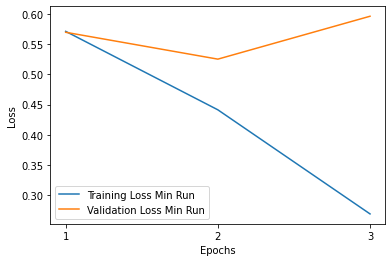

In [34]:
training_loss_min = [0.5717,0.441300,0.2683]
training_loss_max = [0.57460,0.442,0.2661]
val_loss_min = [0.570152,0.525531,0.596814]
val_loss_max = [0.5456659,0.504951,0.583835]
epoch_list=[1,2,3]

plt.figure()
plt.plot(epoch_list,training_loss_min, label="Training Loss Min Run")
plt.plot(epoch_list,val_loss_min, label="Validation Loss Min Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()


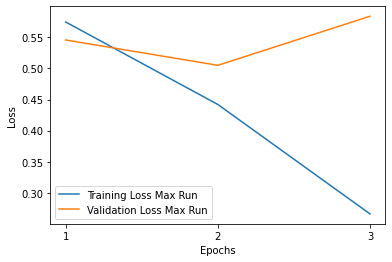

In [35]:

plt.figure()
plt.plot(epoch_list,training_loss_max, label="Training Loss Max Run")
plt.plot(epoch_list,val_loss_max, label="Validation Loss Max Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()